In [1]:
import sys
sys.path.append("../")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import torch
import torch.nn as nn
import numpy as np

from HyperSINDy import Net
from baseline import Trainer
from library_utils import Library
from Datasets import SyntheticDataset
from other import init_weights, make_folder, set_random_seed

from exp_utils import get_equations, log_equations

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

sns.set()

In [2]:
# setting random seed in the methods so the order in which cells are run has less of an effect on
# reproducibility

In [3]:
def load_test_data(data_folder):
    x1 = np.array([np.load(data_folder + "lorenz/scale-1.0/x_test_0.npy")])
    x2 = np.array([np.load(data_folder + "lorenz/scale-5.0/x_test_0.npy")])
    x3 = np.array([np.load(data_folder + "lorenz/scale-10.0/x_test_0.npy")])
    return [x1, x2, x3]

def load_model(device, z_dim, poly_order, include_constant,
               noise_dim, hidden_dim, stat_size, batch_size,
               cp_path):

    torch.cuda.set_device(device=device)
    device = torch.cuda.current_device()

    library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)

    net = Net(library, noise_dim=noise_dim, hidden_dim=hidden_dim,
              statistic_batch_size=stat_size, num_hidden=num_hidden).to(device)
    net.get_masked_coefficients(batch_size=batch_size, device=device)

    cp = torch.load(cp_path, map_location="cuda:" + str(device)) 
    net.load_state_dict(cp['model'])
    net.to(device)
    net = net.eval()
    
    return net, library, device

In [4]:
def sample_trajectory(net, library, device, x0, batch_size=10, dt=1e-2, ts=10000):
    set_random_seed(SEED)
    zc = torch.from_numpy(x0).type(torch.FloatTensor).to(device).unsqueeze(0)
    zc = zc.expand(batch_size, -1)
    zs = []
    for i in range(ts):
        coefs = net.get_masked_coefficients(batch_size=batch_size, device=device)        
        lib = net.library.transform(zc).unsqueeze(1)
        zc = zc + torch.bmm(lib, coefs).squeeze(1) * dt
        zs.append(zc)
    zs = torch.stack(zs, dim=0)
    zs = torch.transpose(zs, 0, 1)
    return zs.detach().cpu().numpy()

def mean_trajectory(net, library, device, x0, dt=1e-2, ts=10000):
    set_random_seed(SEED)
    coefs = net.get_masked_coefficients(device=device).mean(0)
    zc = torch.from_numpy(x0).type(torch.FloatTensor).to(device).unsqueeze(0)
    zs = []
    for i in range(ts):
        lib = net.library.transform(zc)
        zc = zc + torch.matmul(lib, coefs) * dt
        zs.append(zc)
    zs = torch.stack(zs, dim=0)
    zs = torch.transpose(zs, 0, 1)
    return zs.detach().cpu().numpy().squeeze(0)

In [5]:
def plot_samples(x, samples, means, dpi=300, figsize=None, filename=None):    
    sns.set()

    # plotting code adopted partially from
    # https://www.tutorialspoint.com/how-to-hide-axes-but-keep-axis-labels-in-3d-plot-with-matplotlib
    
    for i in range(len(samples)):
        
        if figsize is not None:
            fig = plt.figure(figsize=figsize, dpi=dpi)
        else:
            fig = plt.figure(dpi=dpi)
        
        axes = [fig.add_subplot(1, 3, i + 1, projection='3d') for i in range(3)]
        axes[0].plot(x[i][0][:, 0], x[i][0][:, 1], x[i][0][:,2], color='red')
        axes[1].plot(means[i][:, 0], means[i][:, 1], means[i][:,2], color='purple')
        sample_idx = 0
        curr_sample = samples[i][sample_idx]
        while np.any(np.isnan(curr_sample)):
            sample_idx += 1
            curr_sample = samples[i][sample_idx]
        axes[2].plot(curr_sample[:, 0], curr_sample[:, 1], curr_sample[:,2], color='blue')
        
        color_tuple = (1.0, 1.0, 1.0, 0.0)
        for ax in axes:
            ax.grid(False)
            ax.xaxis.set_pane_color(color_tuple)
            ax.yaxis.set_pane_color(color_tuple)
            ax.zaxis.set_pane_color(color_tuple)
            ax.xaxis.line.set_color(color_tuple)
            ax.yaxis.line.set_color(color_tuple)
            ax.zaxis.line.set_color(color_tuple)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            
        fig.subplots_adjust(hspace=-0.1, wspace=-0.125)
            
        if filename is not None:
            plt.savefig(filename + str(i) + ".png", dpi=300)
        plt.show()
        plt.close()

In [6]:
SEED = 5281998

In [7]:
device = 3
data_folder = "../data/"
model = "HyperSINDy"
dt = 0.01
hidden_dim = 64
stat_size = 250
num_hidden = 5
noise_dim = 6
z_dim = 3
adam_reg = 1e-2
gamma_factor = 0.999
poly_order = 3
include_constant = False
noise_dim = 6
batch_size = 500

In [8]:
net1, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/lorenz/cp_1.pt")
net2, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/lorenz/cp_2.pt")
net3, library, device = load_model(device, z_dim, poly_order, include_constant, 
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  "../runs/lorenz/cp_3.pt")
nets = [net1, net2, net3]

In [9]:
x_test = load_test_data(data_folder)

In [10]:
x0_test = x_test[0][0][0]
samples = [sample_trajectory(nets[i], library, device, x0_test, 10) for i in range(len(nets))]

In [11]:
means = [mean_trajectory(nets[i], library, device, x0_test) for i in range(len(nets))]

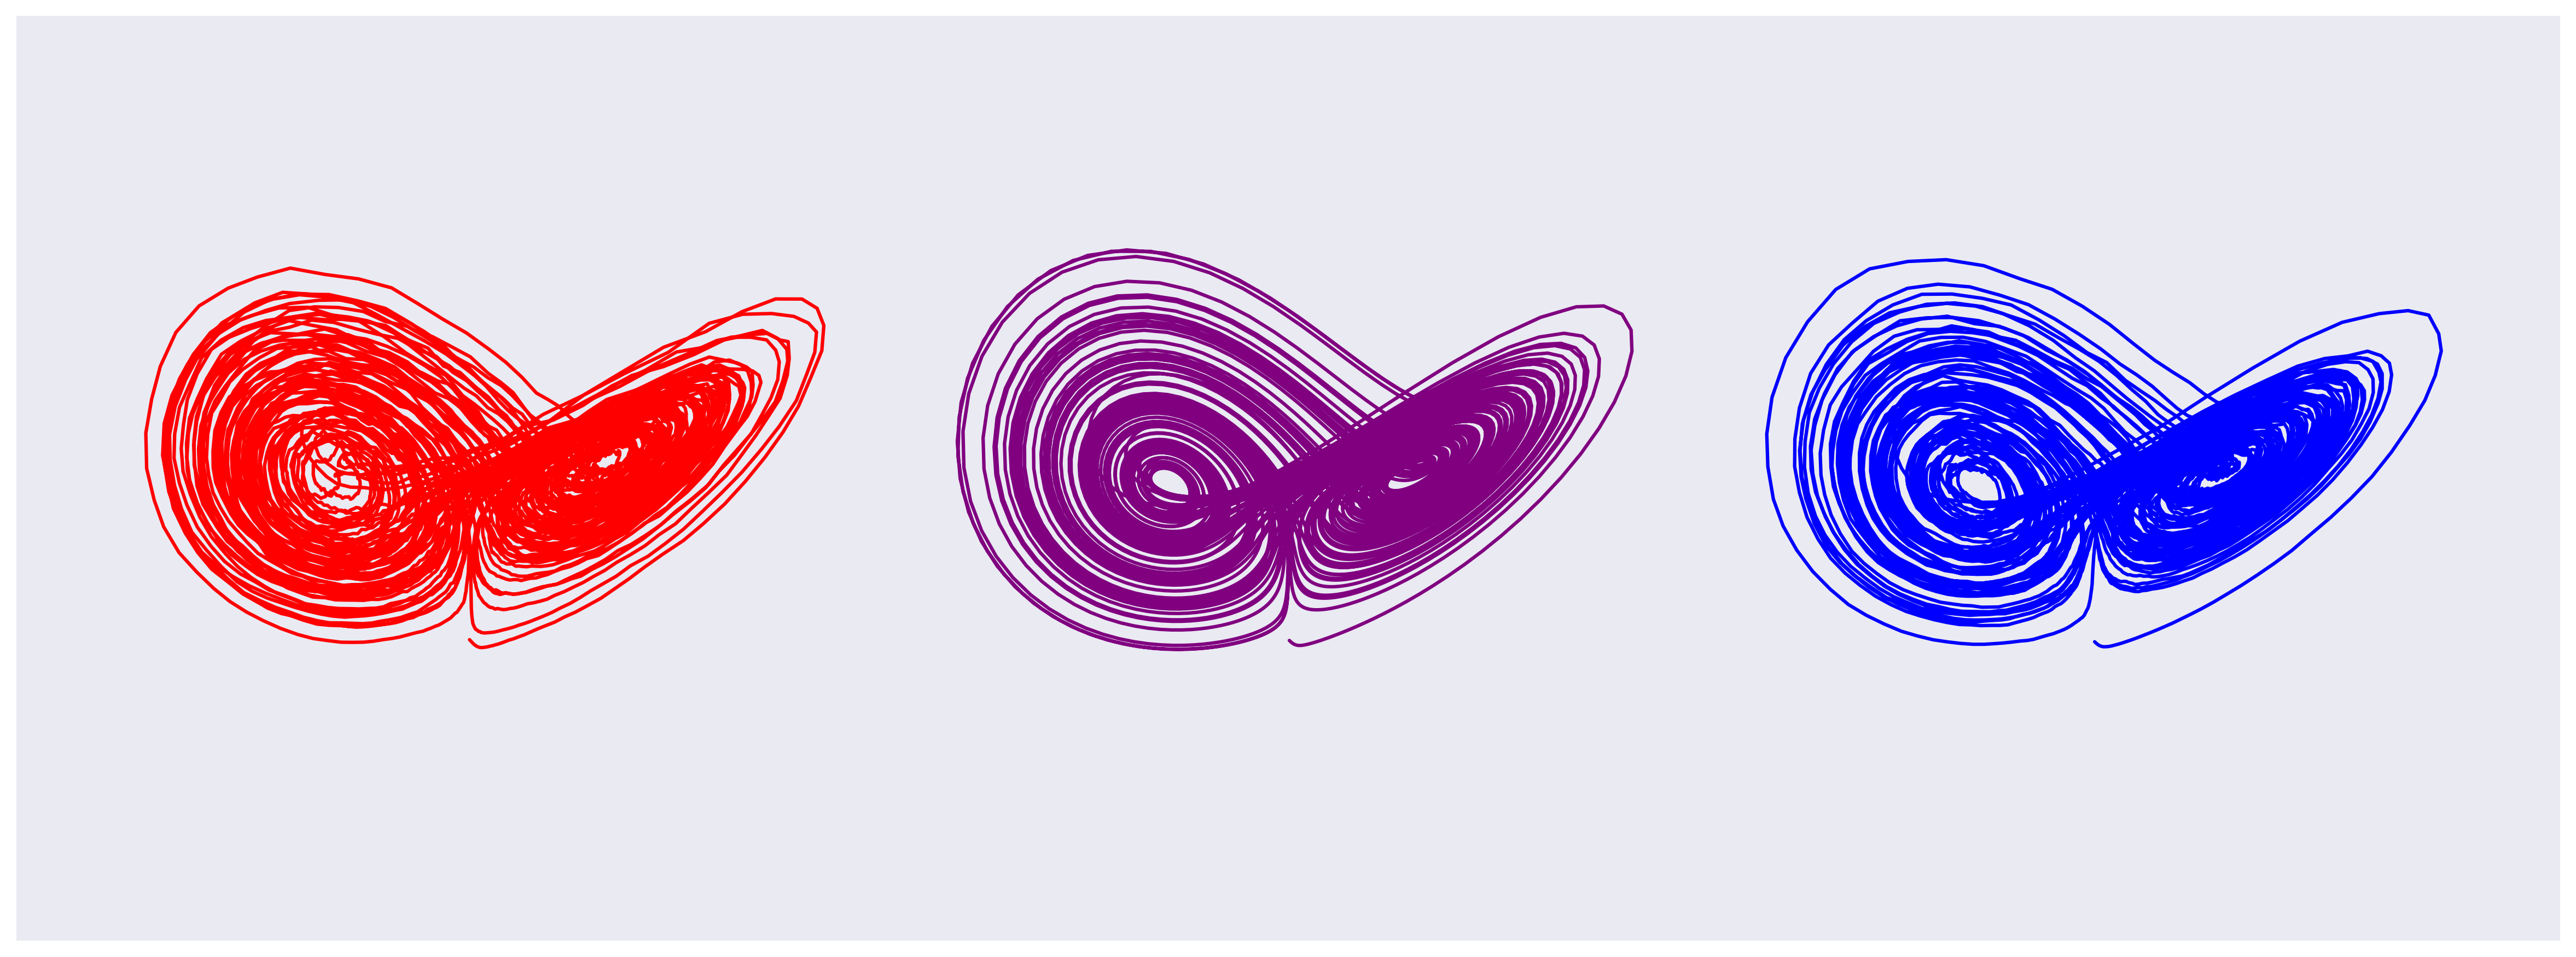

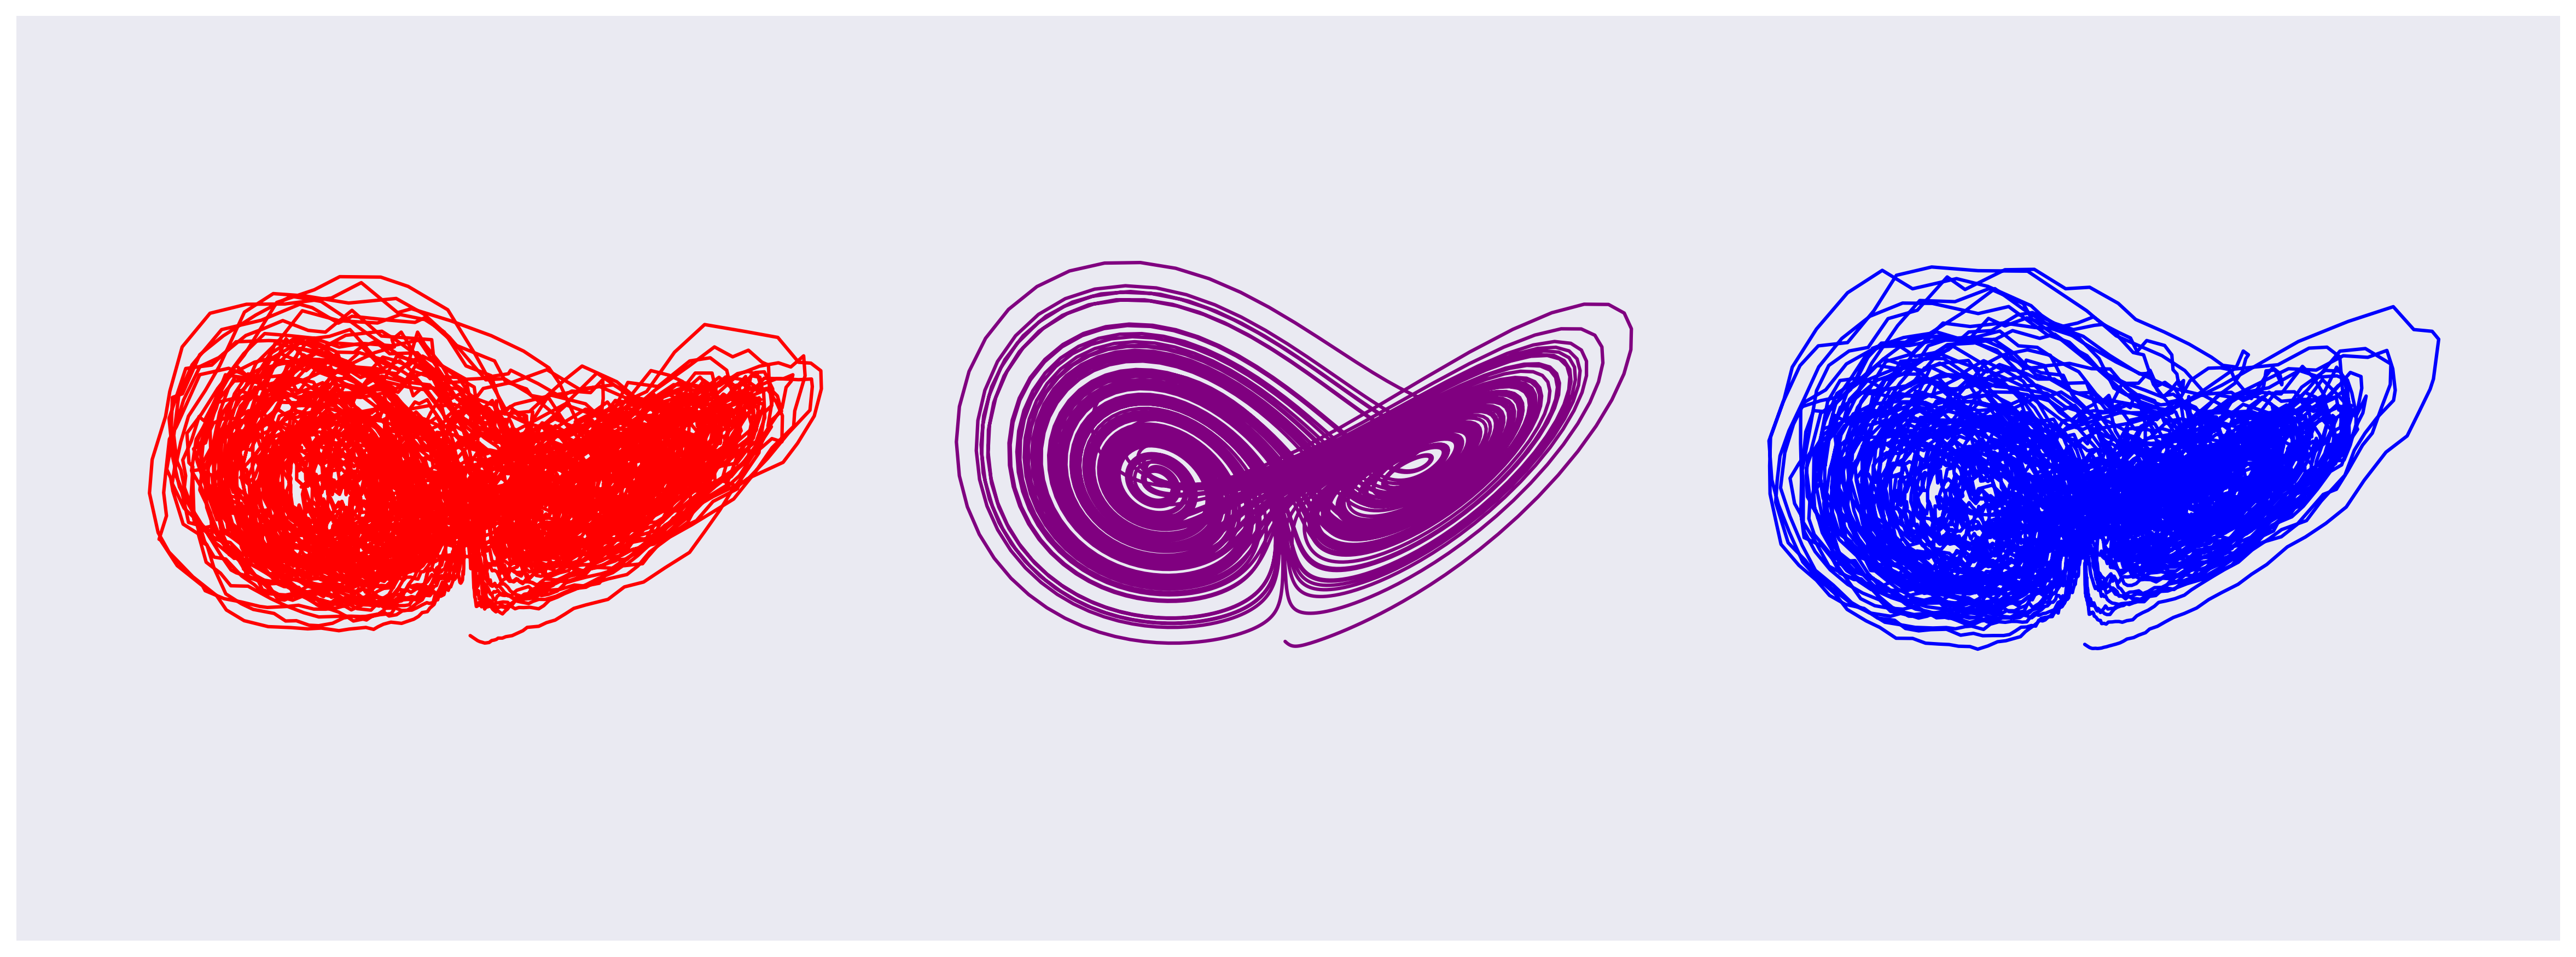

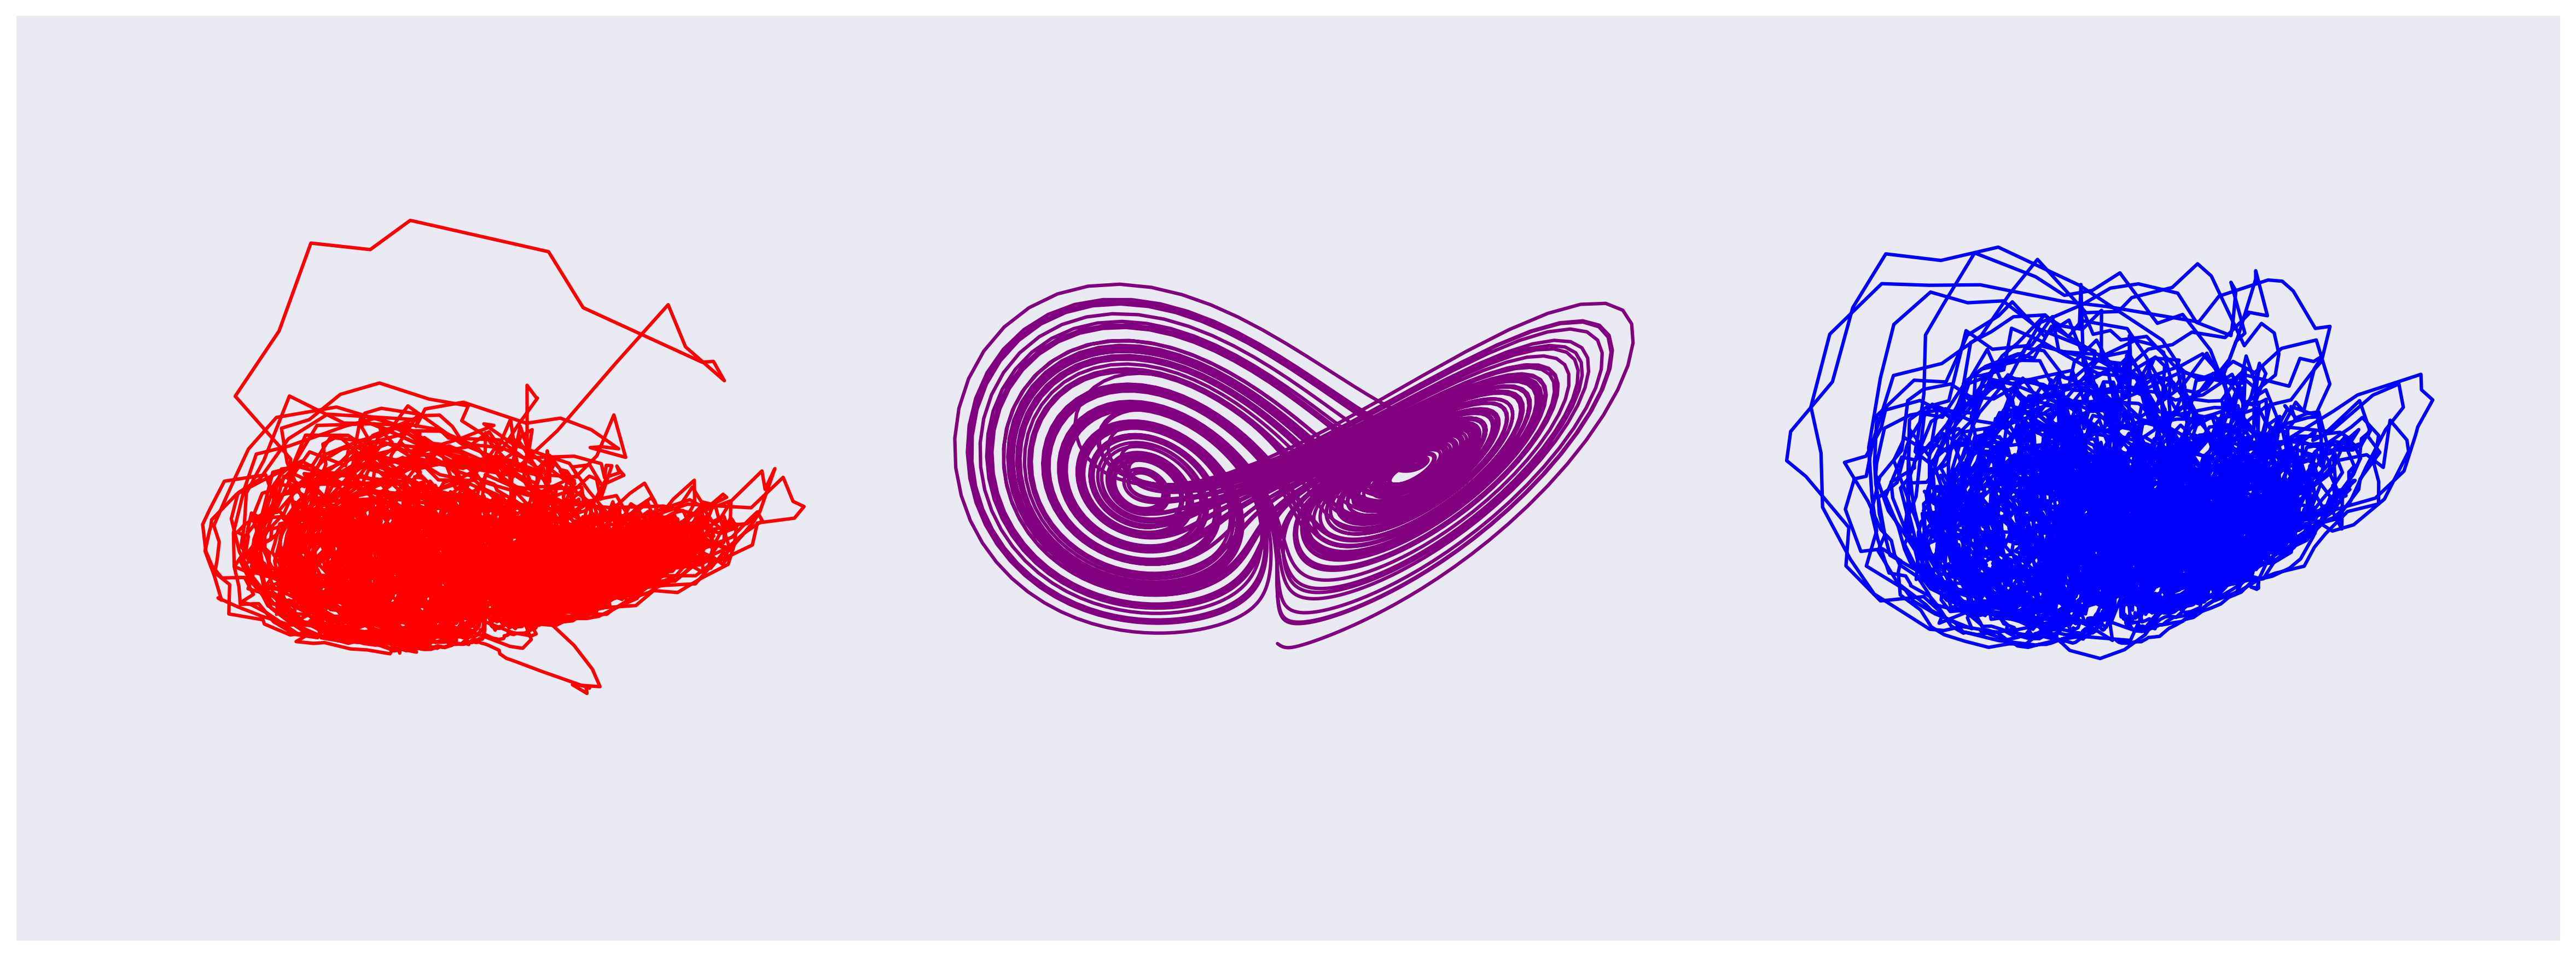

In [12]:
#plot_samples(x_test, samples, means, 300, (20, 20), None)
plot_samples(x_test, samples, means, 300, (20, 20), "../results/fig2a_")

In [13]:
with open("../results/fig2a.txt", "w") as f:
    for net in nets:
        curr_eqs = get_equations(net, library, "HyperSINDy", device, True, seed=SEED)
        for eq in curr_eqs:
            print(eq)
            print(eq, file=f)
        print(file=f)

MEAN
dx = -9.89x + 10.04y
dy = 25.56x + -0.95xz
dz = -2.61z + 1.08xy + -0.08yy
STD
dx = 0.28x + 0.22y
dy = 0.4x + 0.03xz
dz = 0.76z + 0.02xy + 0.01yy
MEAN
dx = -9.74x + 10.02y
dy = 24.62x + 0.22y + -0.92xz
dz = -2.52z + 0.89xy
STD
dx = 3.55x + 3.45y
dy = 2.75x + 0.2y + 0.05xz
dz = 4.11z + 0.02xy
MEAN
dx = -10.0x + 10.24y
dy = 21.38x + 0.95y + -0.83xz
dz = -2.56z + 0.71xy
STD
dx = 7.74x + 6.11y
dy = 6.19x + 3.94y + 0.07xz
dz = 8.59z + 0.04xy
